# Regional Wind Speed produced by using masks created by will and tyler. 
my other notebook was getting way too big so i needed to move it into something more streamlined. this is looking at regional wind speed data from esm4 and cm4 models. hoping to have it split into seaonal plots as well. next steps are using bar plots to show the discrepencies in the two models against oberservational data. 

In [2]:
##importing all the packages needed to run code.
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr ## xarray to make most of the plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean ## for colors on plots
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import zarr ## for google cloud load in
import gcsfs

In [3]:
##importing south polar projection. ## This function was provided by Dr. Beadling in Climate Modeling course.
def South_Polar(array,vmin,vmax,cmap):
    subplot_kws = dict(projection=ccrs.SouthPolarStereo()) 
    fig, ax = plt.subplots(figsize=[10, 5],subplot_kw=subplot_kws)
    
    array.plot.contourf(ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=vmin,
               vmax=vmax,
               extend='both',
               cmap=cmap, levels=45)

    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()

# loading in wind speed data first

# <span style="color:red">CM4 DATA</span>

## eastward wind

In [4]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_uas	
# step two … # replace with the id you need and other info to ween down datasets 
df_u = df_uas.query("source_id=='GFDL-CM4' & experiment_id == 'piControl' & variable_id == 'uas'& table_id == 'Amon'")
df_u
# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas = xr.open_zarr(mapper, consolidated=True)

In [5]:
## selecting the UAS variable and renaming it to Uas_winds.
## This allows us to look at the value we want for eastward wind.
Uas_winds = ds_uas.uas
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
Uas_151_650 = Uas_winds.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
Uas_151_650

<xarray.DataArray 'uas' (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

## seasonal eastward wind 

In [6]:
##UAS wind dataset defined above
Uas_winds
## slicing the UAS into south polar lat
Antsliceuas = Uas_winds.sel(lat=slice(-89.5,-55))
Antsliceuas
## grouping the data into seasons and averaging the 500 seasons
uas_seasonal = Antsliceuas.groupby('time.season').mean(dim='time')
uas_seasonal
## creating seasonal variables
uas_summer = uas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
uas_winter = uas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
uas_spring = uas_seasonal.sel(season='SON') ## spring months in southern hemisphere
uas_fall = uas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

## northward wind

In [7]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_vas	
# step two … # replace with the id you need and other info to ween down datasets 
df_v = df_vas.query("source_id=='GFDL-CM4' & experiment_id == 'piControl' & variable_id == 'vas'& table_id == 'Amon'")
df_v
# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas = xr.open_zarr(mapper, consolidated=True)

In [8]:
## selecting the Vas variable and naming it to Vas_winds. allows us to look at northward winds.
Vas_winds = ds_vas.vas
## slicing Vas_winds to south polar region and averaging 500 year to get average.
Vas_151_650 = Vas_winds.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
Vas_151_650

<xarray.DataArray 'vas' (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

## seasonal northward wind

In [9]:
## VAS data set as defined earlier
Vas_winds
## slicing vas into south pole lat
antslicevas = Vas_winds.sel(lat=slice(-89.5,-55))
## grouping Vas into seasons and averaging the 500 seasons.
vas_seasonal = antslicevas.groupby('time.season').mean(dim='time')
## plotting to see DJF / month values
vas_seasonal
## creating seasonal variables ## im not sure we need these actually...
vas_summer = vas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
vas_winter = vas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
vas_spring = vas_seasonal.sel(season='SON') ## spring months in southern hemisphere
vas_fall = vas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [10]:
## naming CM4 variables like you seen in other notebooks
Uas = ds_uas.uas
Vas = ds_vas.vas

# computing wind speed

In [11]:
## merge winds by merging eastward and northward.
mergewinds = xr.merge([Uas,Vas]) # merge winds to make it easy
xmerge = mergewinds.lon #extracting the lon component fomr the mergewinds array
ymerge = mergewinds.lat
umerge = mergewinds.uas 
vmerge = mergewinds.vas
speedmerge = np.sqrt(np.square(umerge) + np.square(vmerge)) ## calculating speed using vector sum formula
## average
timeaveragemerge = mergewinds.sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
timeaveragemerge

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Data variables:
    uas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [12]:
### slicing the speed for the south pole
speedslice = speedmerge.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')

In [13]:
## UAS seasonal dataset
uas_seasonal
## VAS seasonal plot
vas_seasonal
## merging the UAS seasonal and Vas seasonal to get merge seasonal
seasonalmerge = xr.merge([uas_seasonal,vas_seasonal])
seasonalmerge

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 288, season: 4)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    uas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
    vas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [14]:
## calculating the seasonal wind speed
seasonalspeedmerge = np.sqrt(np.square(seasonalmerge.uas) + np.square(seasonalmerge.vas))
## slicing the summer speed
Summer_szn_speed = seasonalspeedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
Summer_szn= seasonalmerge.sel(season='DJF')
## slicing seasonalspeed to get speed for winter and averaging it
Winter_szn_speed = seasonalspeedmerge.sel(season=slice('JJA')).mean(dim='season')
Winter_szn= seasonalmerge.sel(season='JJA')
## FALL seasonal speed merge and averaging
Fall_szn_speed = seasonalspeedmerge.sel(season=slice('MAM')).mean(dim='season')
Fall_szn= seasonalmerge.sel(season='MAM')
## slicing seasonalspeed to get spring values and averaging it
Spring_szn_speed = seasonalspeedmerge.sel(season=slice('SON')).mean(dim='season')
Spring_szn= seasonalmerge.sel(season='SON')

# <span style="color:red">ESM4 DATA</span>

In [15]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [16]:
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True).uas.rename({'lat':'latitude',
                                                             'lon':'longitude'})

#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True).vas.rename({'lat':'latitude',
                                                             'lon':'longitude'})

In [17]:
uase4=esm4_uas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')#.groupby('time.season').mean(dim='time')
vase4 = esm4_vas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')

## eastward wind

In [18]:
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
uase4_500_avg=uase4.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')

## eastward seasonal wind

In [19]:
uase4 #eastward wind variable
## slicing the uase4 into south polar lat
ESM4_Antsliceuas = uase4.sel(latitude=slice(-89.5,-55))
ESM4_Antsliceuas
## grouping the data into seasons and averaging the 500 seasons
ESM4_uas_seasonal = ESM4_Antsliceuas.groupby('time.season').mean(dim='time')
ESM4_uas_seasonal
## grouping into seasonal varibles 
ESM4_uas_summer = ESM4_uas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
ESM4_uas_winter = ESM4_uas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
ESM4_uas_spring = ESM4_uas_seasonal.sel(season='SON') ## spring months in southern hemisphere
ESM4_uas_fall = ESM4_uas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

## northward wind

In [20]:
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
vase4_500_avg=vase4.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')

## northward seaonsal wind 

In [21]:
vase4 #northward wind variable
## slicing the vase4 into south polar lat
ESM4_Antslicevas = vase4.sel(latitude=slice(-89.5,-55))
ESM4_Antslicevas
## grouping the data into seasons and averaging the 500 seasons
ESM4_vas_seasonal = ESM4_Antslicevas.groupby('time.season').mean(dim='time')
ESM4_vas_seasonal
## creating seasonal variables 
ESM4_vas_summer = ESM4_vas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
ESM4_vas_winter = ESM4_vas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
ESM4_vas_spring = ESM4_vas_seasonal.sel(season='SON') ## spring months in southern hemisphere
ESM4_vas_fall = ESM4_vas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

# computing wind speed

In [22]:
uase4=esm4_uas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')#.groupby('time.season').mean(dim='time')
vase4 = esm4_vas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')
mergedwindse4 = xr.merge([uase4,vase4])
esm4_xmerge=mergedwindse4.longitude
esm4_ymerge=mergedwindse4.latitude
esm4_umerge=mergedwindse4.uas
esm4_vmerge=mergedwindse4.vas
esm4_speed_merge=np.sqrt(np.square(esm4_umerge) + np.square(esm4_vmerge)).sel(latitude=slice(-90,-55))
esm4_speed_merge
#wind speed around antarctica 
#####
esm4_timeaveragemerge = mergedwindse4.sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
esm4_timeaveragemerge

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 288)
Coordinates:
    height     float64 10.0
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Data variables:
    uas        (latitude, longitude) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas        (latitude, longitude) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [41]:
### slicing the speed for the south pole
ESM4_speedslice = esm4_speed_merge.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
ESM4_speedslice
##
ESM4_uas_seasonal #defined earlier
ESM4_vas_seasonal #defined earlier
## merging the UAS seasonal and Vas seasonal to get merge seasonal
esm4_seasonalmerge = xr.merge([ESM4_uas_seasonal,ESM4_vas_seasonal])
esm4_seasonalmerge
##
## calculating the seasonal wind speed
esm4_SPEED_seasonalmerge = np.sqrt(np.square(esm4_seasonalmerge.uas) + np.square(esm4_seasonalmerge.vas))
esm4_SPEED_seasonalmerge
## merging the UAS seasonal and Vas seasonal to get merge seasonal
esm4_seasonalmerge = xr.merge([ESM4_uas_seasonal,ESM4_vas_seasonal])
esm4_seasonalmerge
#this has the same variables

<xarray.Dataset>
Dimensions:    (latitude: 35, longitude: 288, season: 4)
Coordinates:
    height     float64 10.0
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... -57.5 -56.5 -55.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    uas        (season, latitude, longitude) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
    vas        (season, latitude, longitude) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [42]:
esm4_SPEED_seasonalmerge = np.sqrt(np.square(esm4_seasonalmerge.uas) + np.square(esm4_seasonalmerge.vas))
esm4_SPEED_seasonalmerge
## slicing the summer speed
ESM4_Summer_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
ESM4_Summer_szn= esm4_seasonalmerge.sel(season='DJF') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL
## slicing the winter speed
ESM4_winter_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('JJA')).mean(dim='season')
## Slicing winter season from seasonalmerge
ESM4_winter_szn= esm4_seasonalmerge.sel(season='JJA') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL
## slicing the fall speed
ESM4_fall_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('MAM')).mean(dim='season')
## Slicing fall season from seasonalmerge
ESM4_fall_szn= esm4_seasonalmerge.sel(season='MAM') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL
## slicing the spring speed
ESM4_spring_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('SON')).mean(dim='season')
## Slicing spring season from seasonalmerge
ESM4_spring_szn= esm4_seasonalmerge.sel(season='SON') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

# <span style="color:red">APPLYING REGIONAL MASKS</span>

In [47]:
def south_pole_map(cols=1, rows=1, fig_size=(12,8), max_extent=-50, facecolor='white'):
    '''
    User note: In order to call the function, begin cell with: fig, ax = south_pole_map(**args).
    Neglecting "fig, ax =" at the begeinning will not map your data to the existing axes.
    This function sets up a polar projection centered at the South Pole, which DataArrays can be plotted over.
    Optional arguments accepted for figure size, maximum (northward) extent and facecolor. Any number of columns and/or rows are also accepted for multiple subplots.
    If creating multiple subplots, ax=ax[*index*] must be passed in the plot call for each array.
    By default, these are set to (12,8), -50ºS and gray, respectively. Columns/Rows set to 1 by default – specifying axes in which to plot data is not necessary when using default column number.
    '''
    import matplotlib.path as mpath
    import numpy as np
    import cartopy.crs as ccrs
    fig,ax = plt.subplots(figsize=fig_size, ncols=cols, nrows=rows, subplot_kw={'projection': ccrs.SouthPolarStereo(), 'facecolor':facecolor}, layout='constrained')
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    if rows>1 and cols>1:
        for i in range(rows):
            for j in range(cols):
                ax[i,j].set_boundary(circle, transform=ax[i,j].transAxes)
                # lat/long map extents. shows south pole out to 50ºS
                ax[i,j].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif cols>1 and rows==1:
        for i in range(cols):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)
            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif rows>1 and cols==1:
        for i in range(rows):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)
            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    else:
        ax.set_boundary(circle, transform=ax.transAxes)
            # lat/long map extents. shows south pole out to 50ºS
        ax.set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    #must return fig, ax when creating multiple subplots in a function
    return fig, ax

# <span style="color:red">CM4 DATA</span>

In [48]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')

In [49]:
CM4_speedslice_test=speedslice #redefining variable
## speed slice sliced windspeed over the south pole region and averaged out time 

In [50]:
plateau_speed=(CM4_speedslice_test*(mask_CM4.plateau_CM4))
ross_speed=( CM4_speedslice_test*(mask_CM4.ross_CM4))
lowwest_speed=(CM4_speedslice_test*(mask_CM4.lowwest_CM4))
loweast_speed=(CM4_speedslice_test*(mask_CM4.loweast_CM4))
filchner_speed=(CM4_speedslice_test*(mask_CM4.filchner_CM4))
peninsula_speed=(CM4_speedslice_test*(mask_CM4.peninsula_CM4))

Text(0.5, 0.98, 'Average Annual Wind Speed (m/s) Over 500 years')

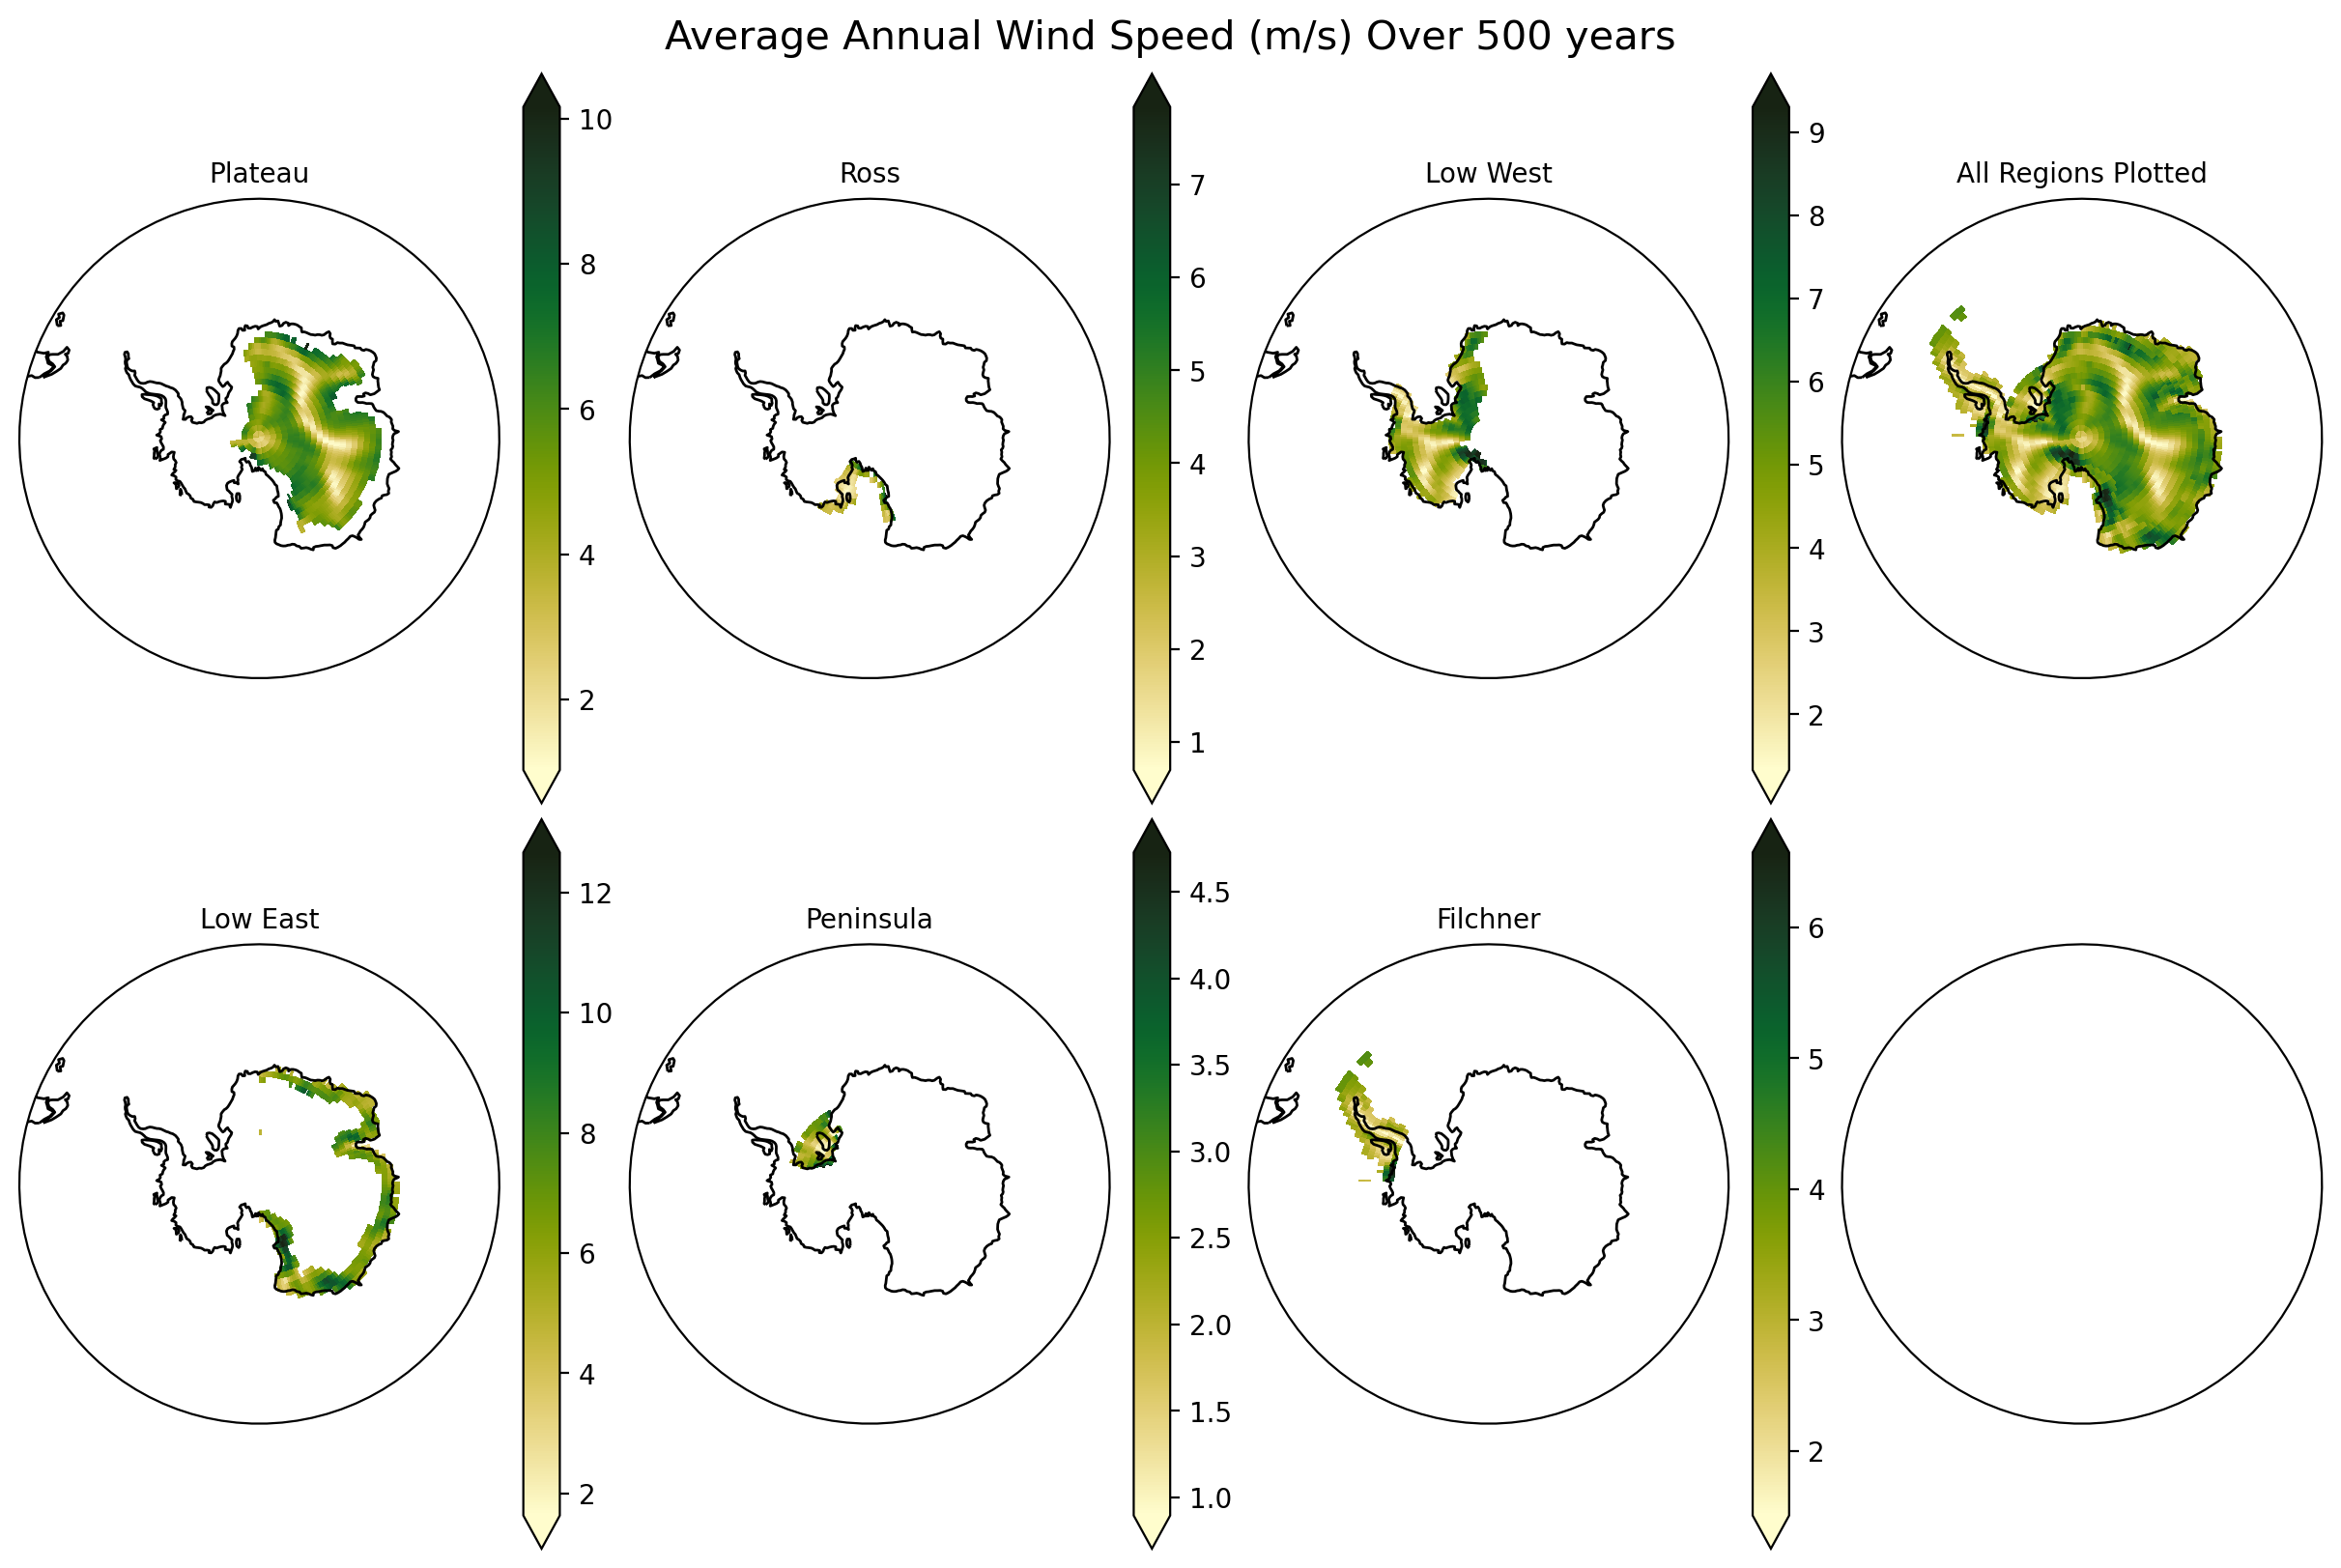

In [28]:
fig, ax = south_pole_map(cols=4, rows=2,fig_size=(12,8))
plateau_speed.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
ross_speed.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
lowwest_speed.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed)
loweast_speed.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
               extend='both',
               cmap= cmocean.cm.speed)
filchner_speed.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
peninsula_speed.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
plateau_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
ross_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
lowwest_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
loweast_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
filchner_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
peninsula_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[0,3].coastlines()
ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[0,3].set_title('All Regions Plotted',size=10)
fig.suptitle('Average Annual Wind Speed (m/s) Over 500 years', fontsize=15)

In [29]:
# Summer Regional Wind Speed

In [30]:
Summer_szn_speed

<xarray.DataArray (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [31]:
summer_plateau_speed=(Summer_szn_speed*(mask_CM4.plateau_CM4))
summer_ross_speed=(Summer_szn_speed*(mask_CM4.ross_CM4))
summer_lowwest_speed=(Summer_szn_speed*(mask_CM4.lowwest_CM4))
summer_loweast_speed=(Summer_szn_speed*(mask_CM4.loweast_CM4))
summer_filchner_speed=(Summer_szn_speed*(mask_CM4.filchner_CM4))
summer_peninsula_speed=(Summer_szn_speed*(mask_CM4.peninsula_CM4))

Text(0.5, 0.98, 'Summer Wind Speed (m/s)')

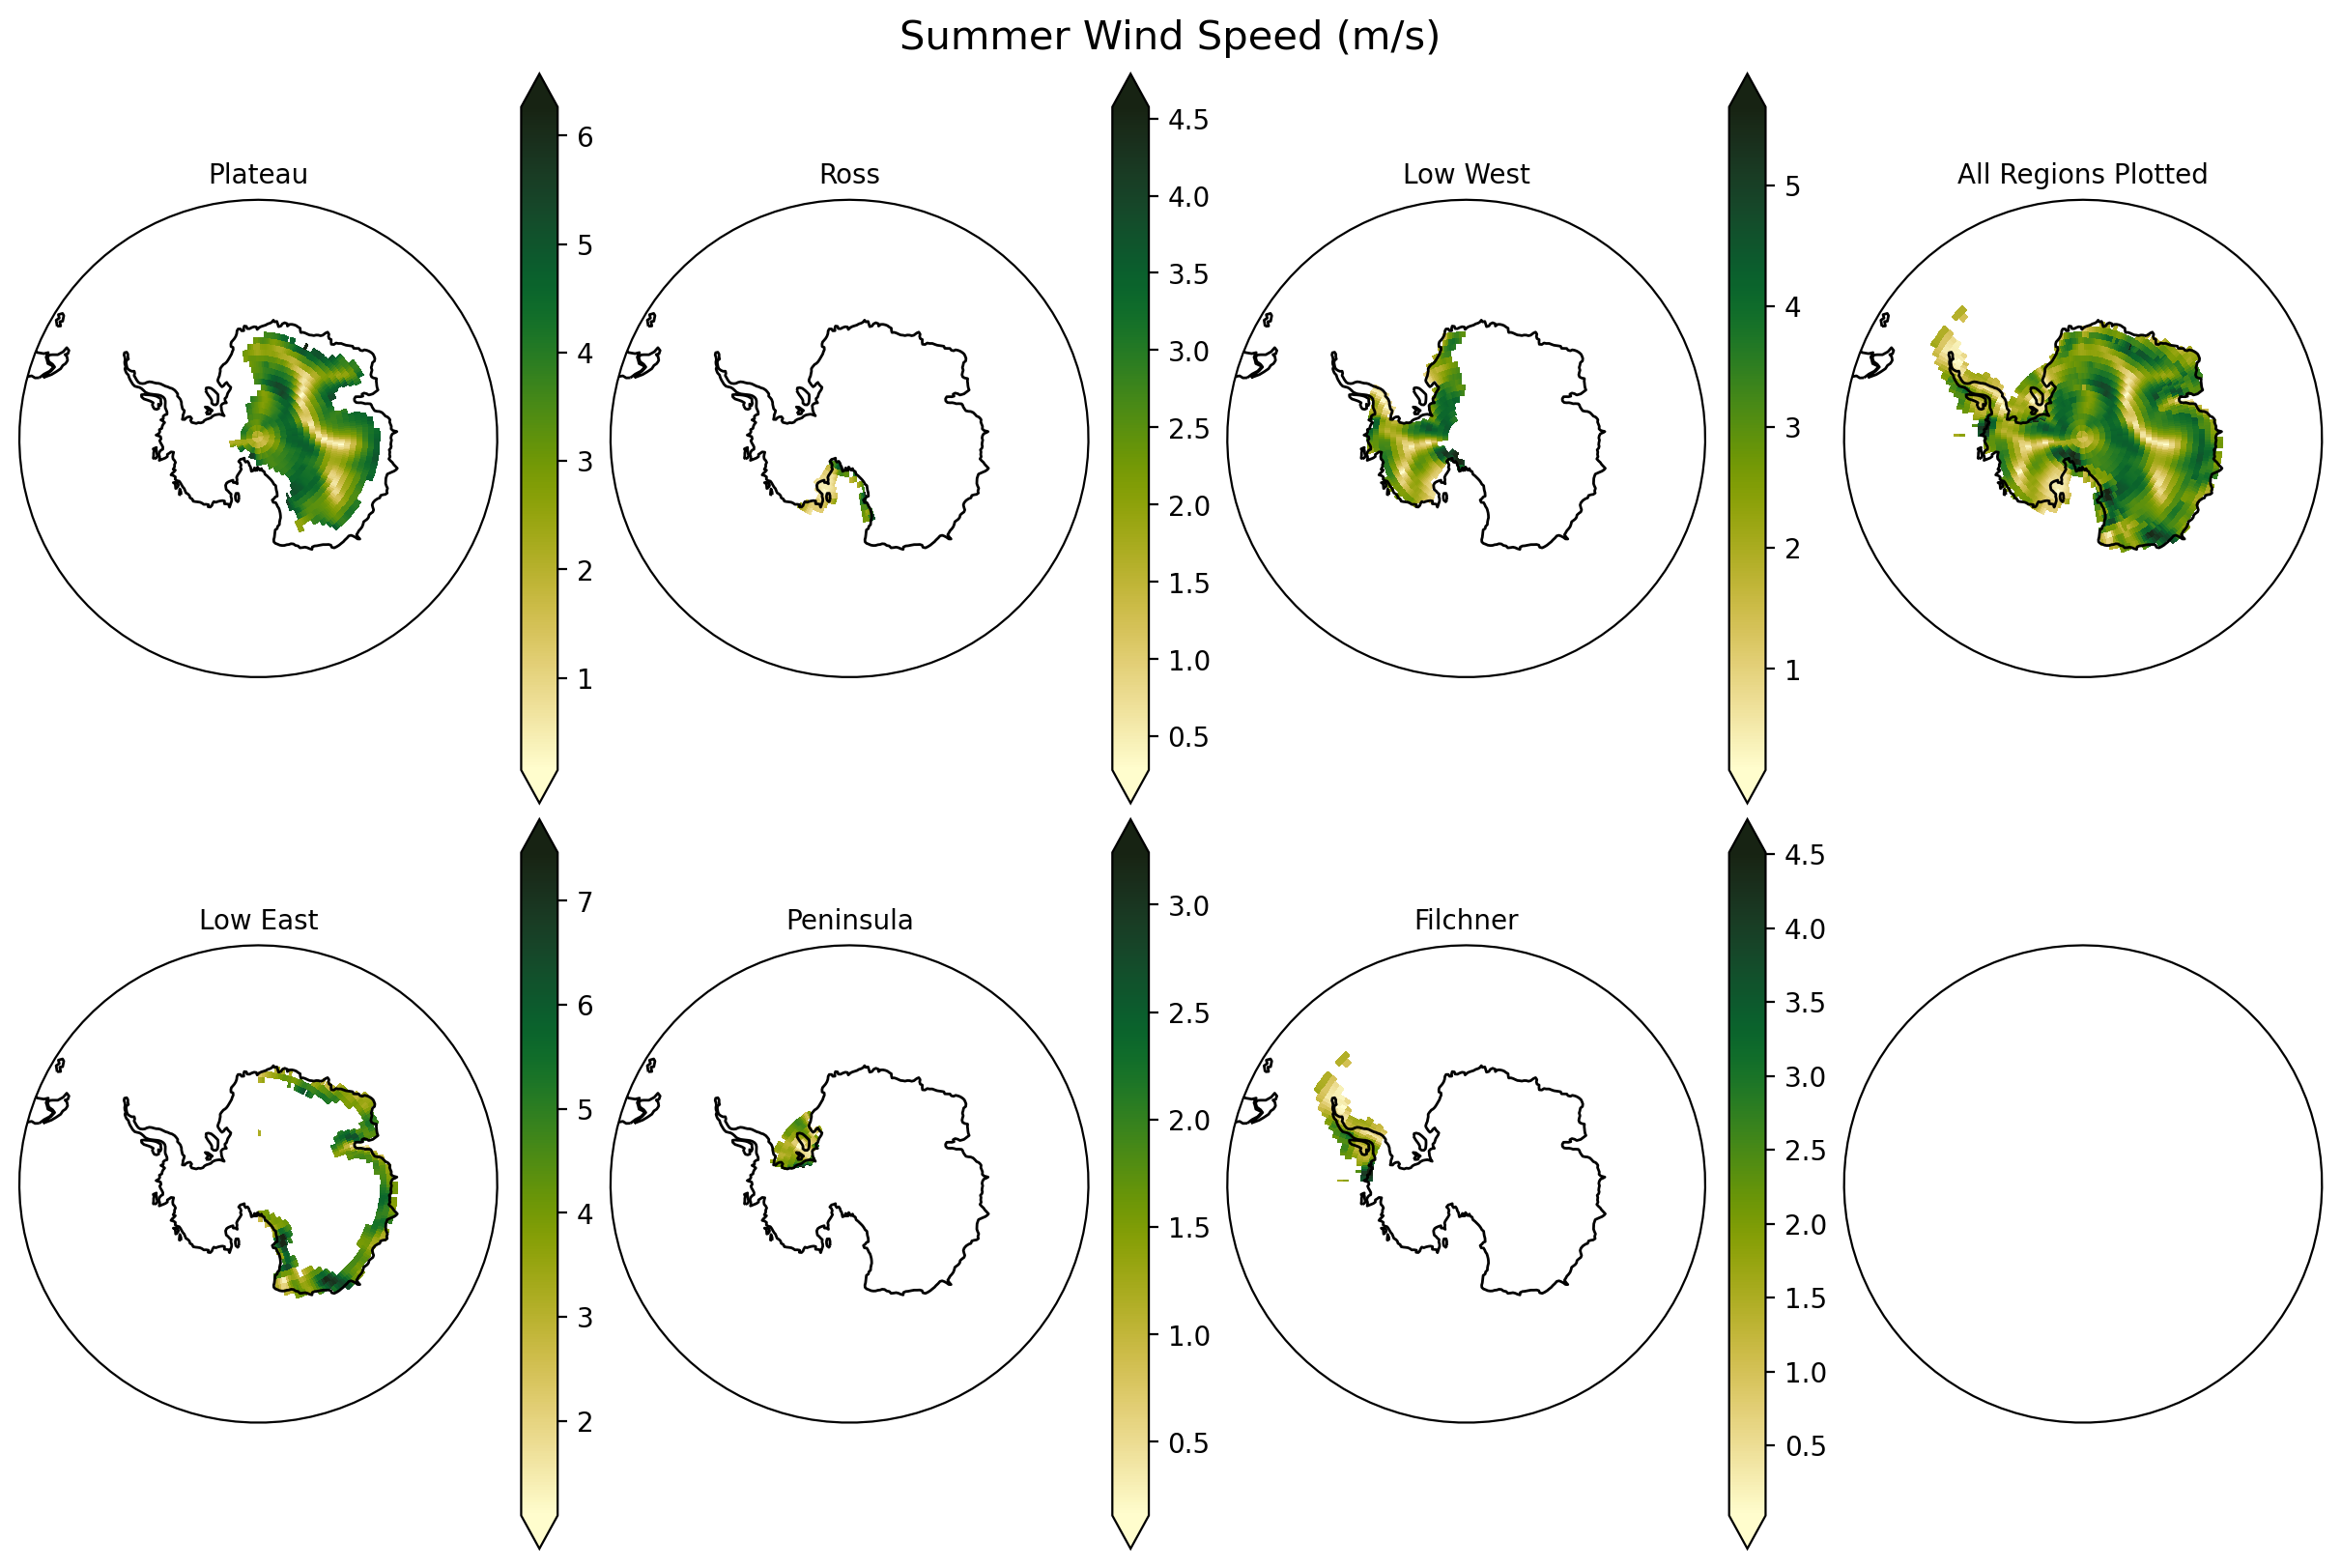

In [32]:
fig, ax = south_pole_map(cols=4, rows=2,fig_size=(12,8))
summer_plateau_speed.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
summer_ross_speed.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
summer_lowwest_speed.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed)
summer_loweast_speed.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
               extend='both',
               cmap= cmocean.cm.speed)
summer_filchner_speed.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
summer_peninsula_speed.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
summer_plateau_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
summer_ross_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
summer_lowwest_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
summer_loweast_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
summer_filchner_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
summer_peninsula_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[0,3].coastlines()
ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[0,3].set_title('All Regions Plotted',size=10)
fig.suptitle('Summer Wind Speed (m/s)', fontsize=15)

In [33]:
Winter_szn_speed
#winter szn
winter_plateau_speed=(Winter_szn_speed*(mask_CM4.plateau_CM4))
winter_ross_speed=(Winter_szn_speed*(mask_CM4.ross_CM4))
winter_lowwest_speed=(Winter_szn_speed*(mask_CM4.lowwest_CM4))
winter_loweast_speed=(Winter_szn_speed*(mask_CM4.loweast_CM4))
winter_filchner_speed=(Winter_szn_speed*(mask_CM4.filchner_CM4))
winter_peninsula_speed=(Winter_szn_speed*(mask_CM4.peninsula_CM4))

Text(0.5, 0.98, 'Winter Wind Speed (m/s)')

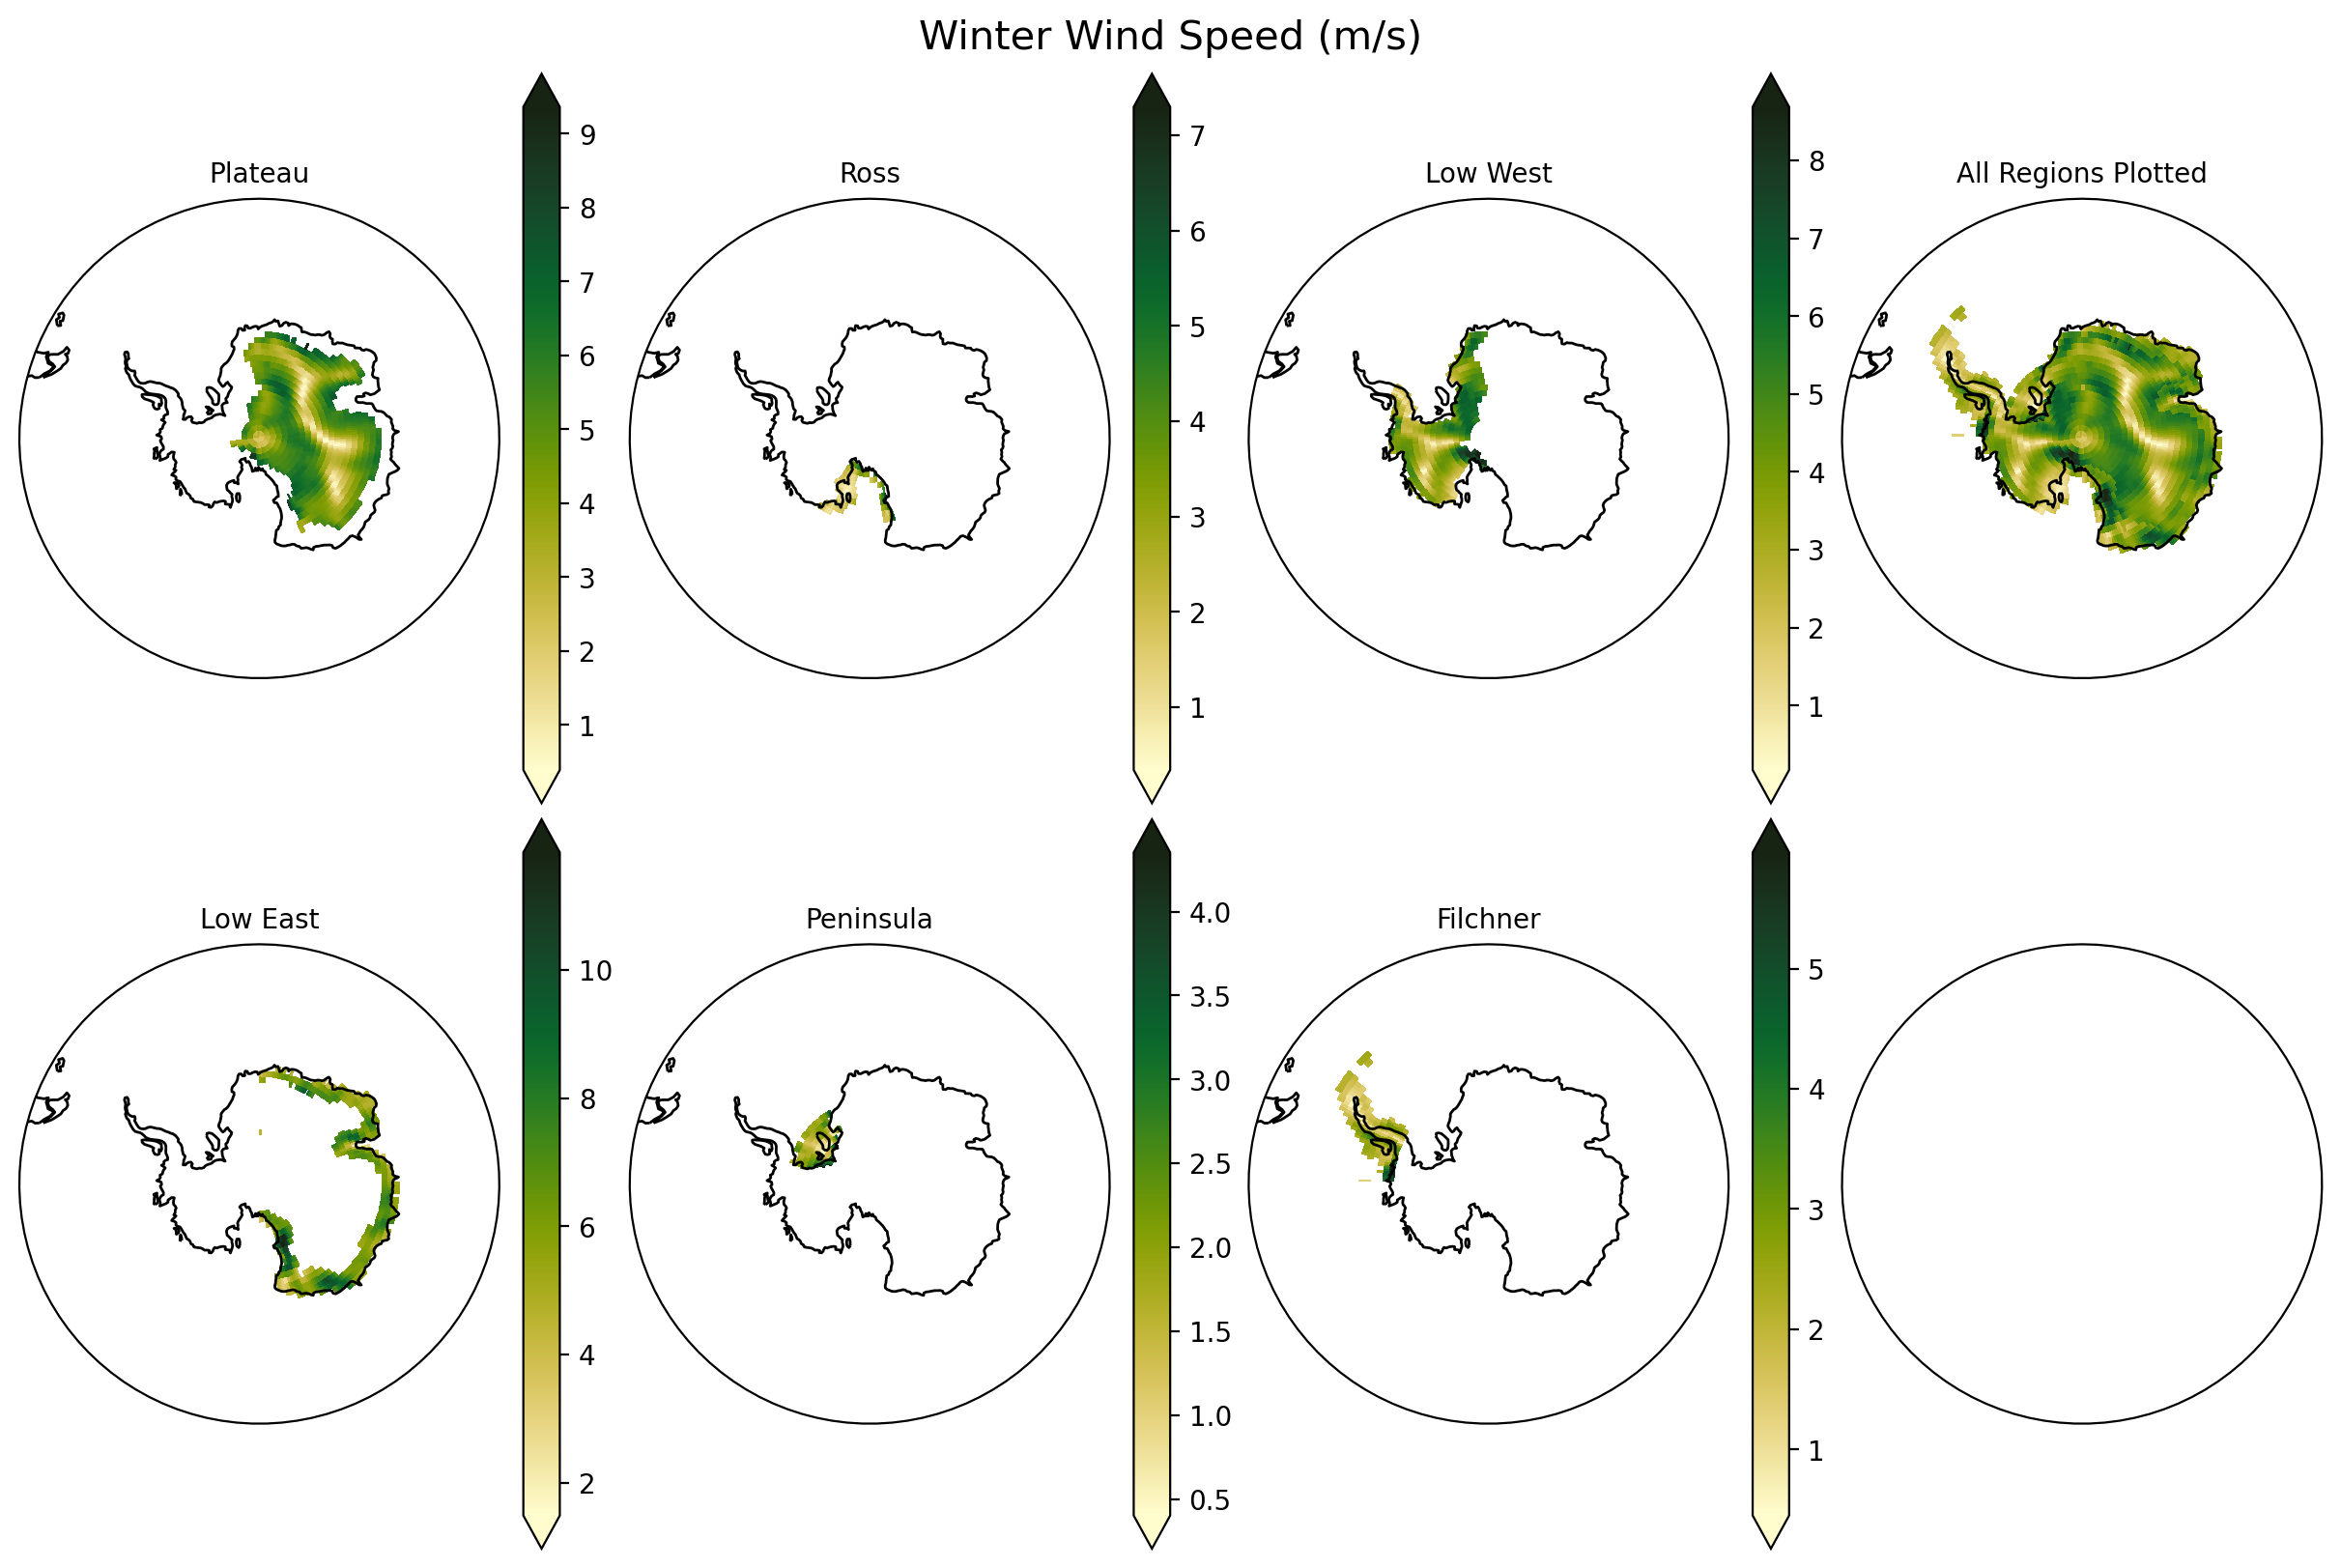

In [34]:
fig, ax = south_pole_map(cols=4, rows=2,fig_size=(12,8))
winter_plateau_speed.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
winter_ross_speed.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
winter_lowwest_speed.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed)
winter_loweast_speed.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
               extend='both',
               cmap= cmocean.cm.speed)
winter_filchner_speed.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
winter_peninsula_speed.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
winter_plateau_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
winter_ross_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
winter_lowwest_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
winter_loweast_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
winter_filchner_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
winter_peninsula_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[0,3].coastlines()
ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[0,3].set_title('All Regions Plotted',size=10)
fig.suptitle('Winter Wind Speed (m/s)', fontsize=15)

In [35]:
Fall_szn_speed

<xarray.DataArray (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [36]:
fall_plateau_speed=(Fall_szn_speed*(mask_CM4.plateau_CM4))
fall_ross_speed=(Fall_szn_speed*(mask_CM4.ross_CM4))
fall_lowwest_speed=(Fall_szn_speed*(mask_CM4.lowwest_CM4))
fall_loweast_speed=(Fall_szn_speed*(mask_CM4.loweast_CM4))
fall_filchner_speed=(Fall_szn_speed*(mask_CM4.filchner_CM4))
fall_peninsula_speed=(Fall_szn_speed*(mask_CM4.peninsula_CM4))

Text(0.5, 0.98, 'Fall Wind Speed (m/s) Over 500 years')

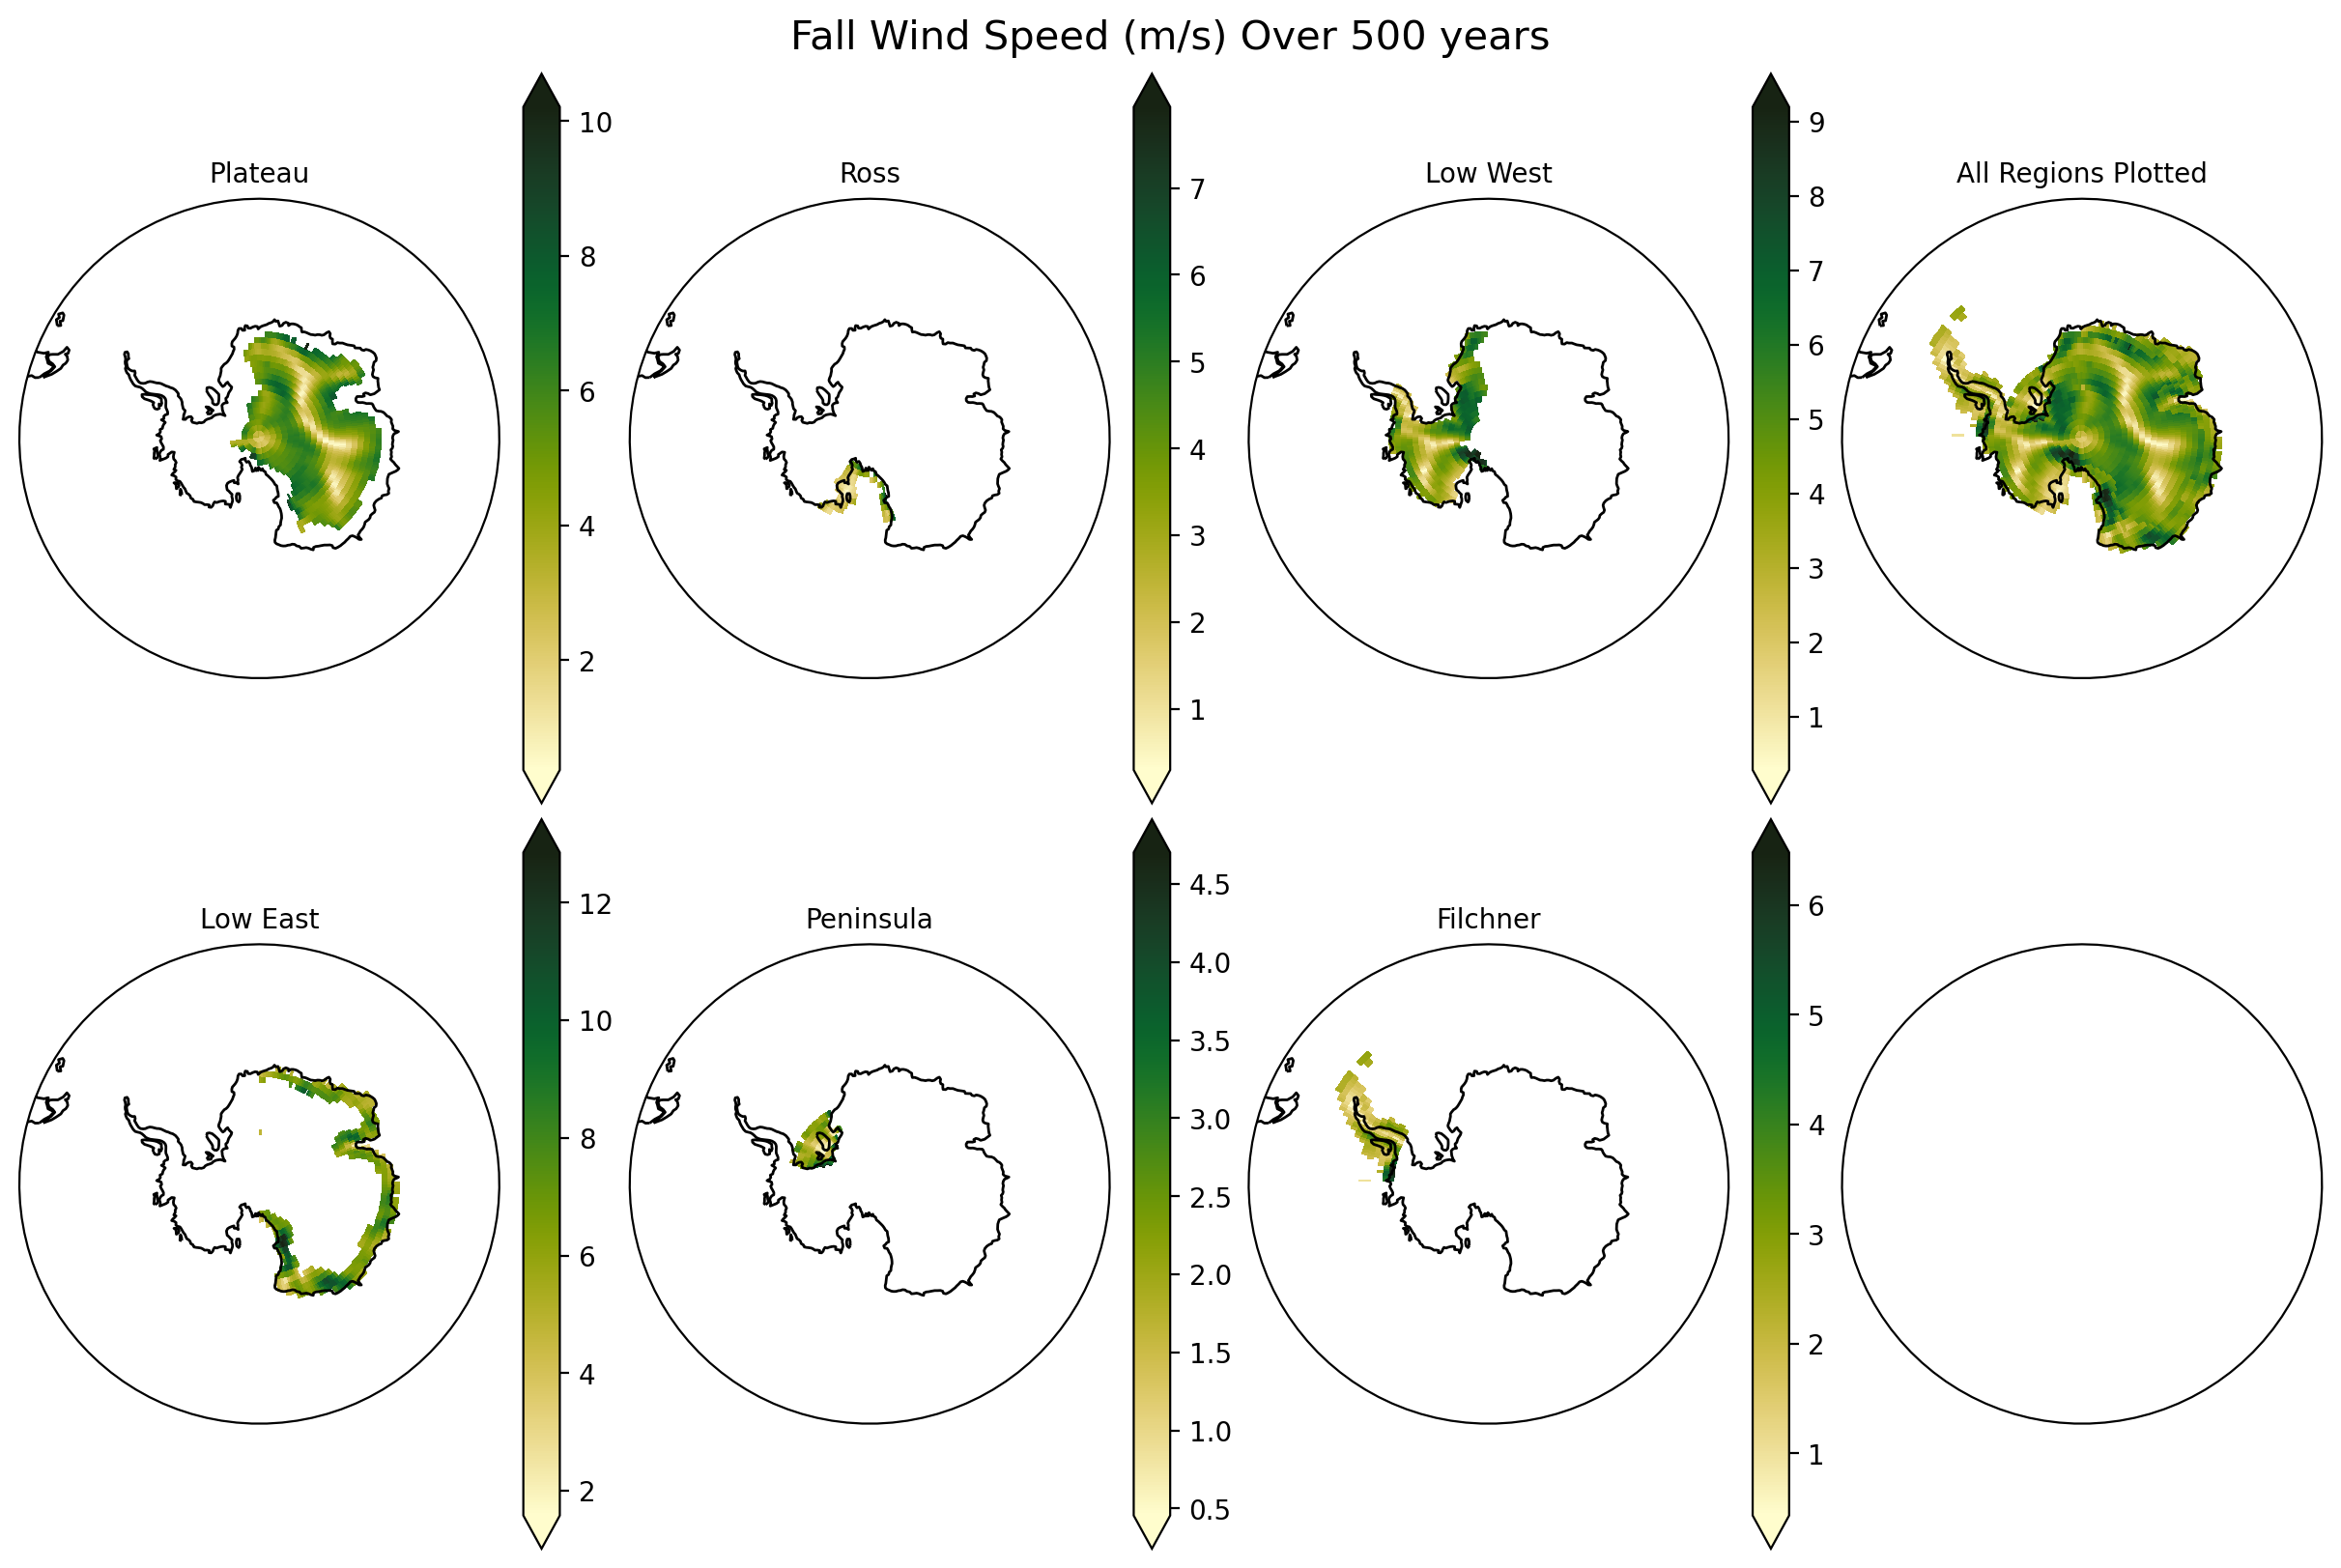

In [43]:
fig, ax = south_pole_map(cols=4, rows=2,fig_size=(12,8))
fall_plateau_speed.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
fall_ross_speed.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
fall_lowwest_speed.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed)
fall_loweast_speed.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
               extend='both',
               cmap= cmocean.cm.speed)
fall_filchner_speed.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
fall_peninsula_speed.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
fall_plateau_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
fall_ross_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
fall_lowwest_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
fall_loweast_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
fall_filchner_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
fall_peninsula_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[0,3].coastlines()
ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[0,3].set_title('All Regions Plotted',size=10)
fig.suptitle('Fall Wind Speed (m/s) Over 500 years', fontsize=15)

In [38]:
Spring_szn_speed

<xarray.DataArray (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [39]:
spring_plateau_speed=(Spring_szn_speed*(mask_CM4.plateau_CM4))
spring_ross_speed=(Spring_szn_speed*(mask_CM4.ross_CM4))
spring_lowwest_speed=(Spring_szn_speed*(mask_CM4.lowwest_CM4))
spring_loweast_speed=(Spring_szn_speed*(mask_CM4.loweast_CM4))
spring_filchner_speed=(Spring_szn_speed*(mask_CM4.filchner_CM4))
spring_peninsula_speed=(Spring_szn_speed*(mask_CM4.peninsula_CM4))

Text(0.5, 0.98, 'Spring Wind Speed (m/s) Over 500 years')

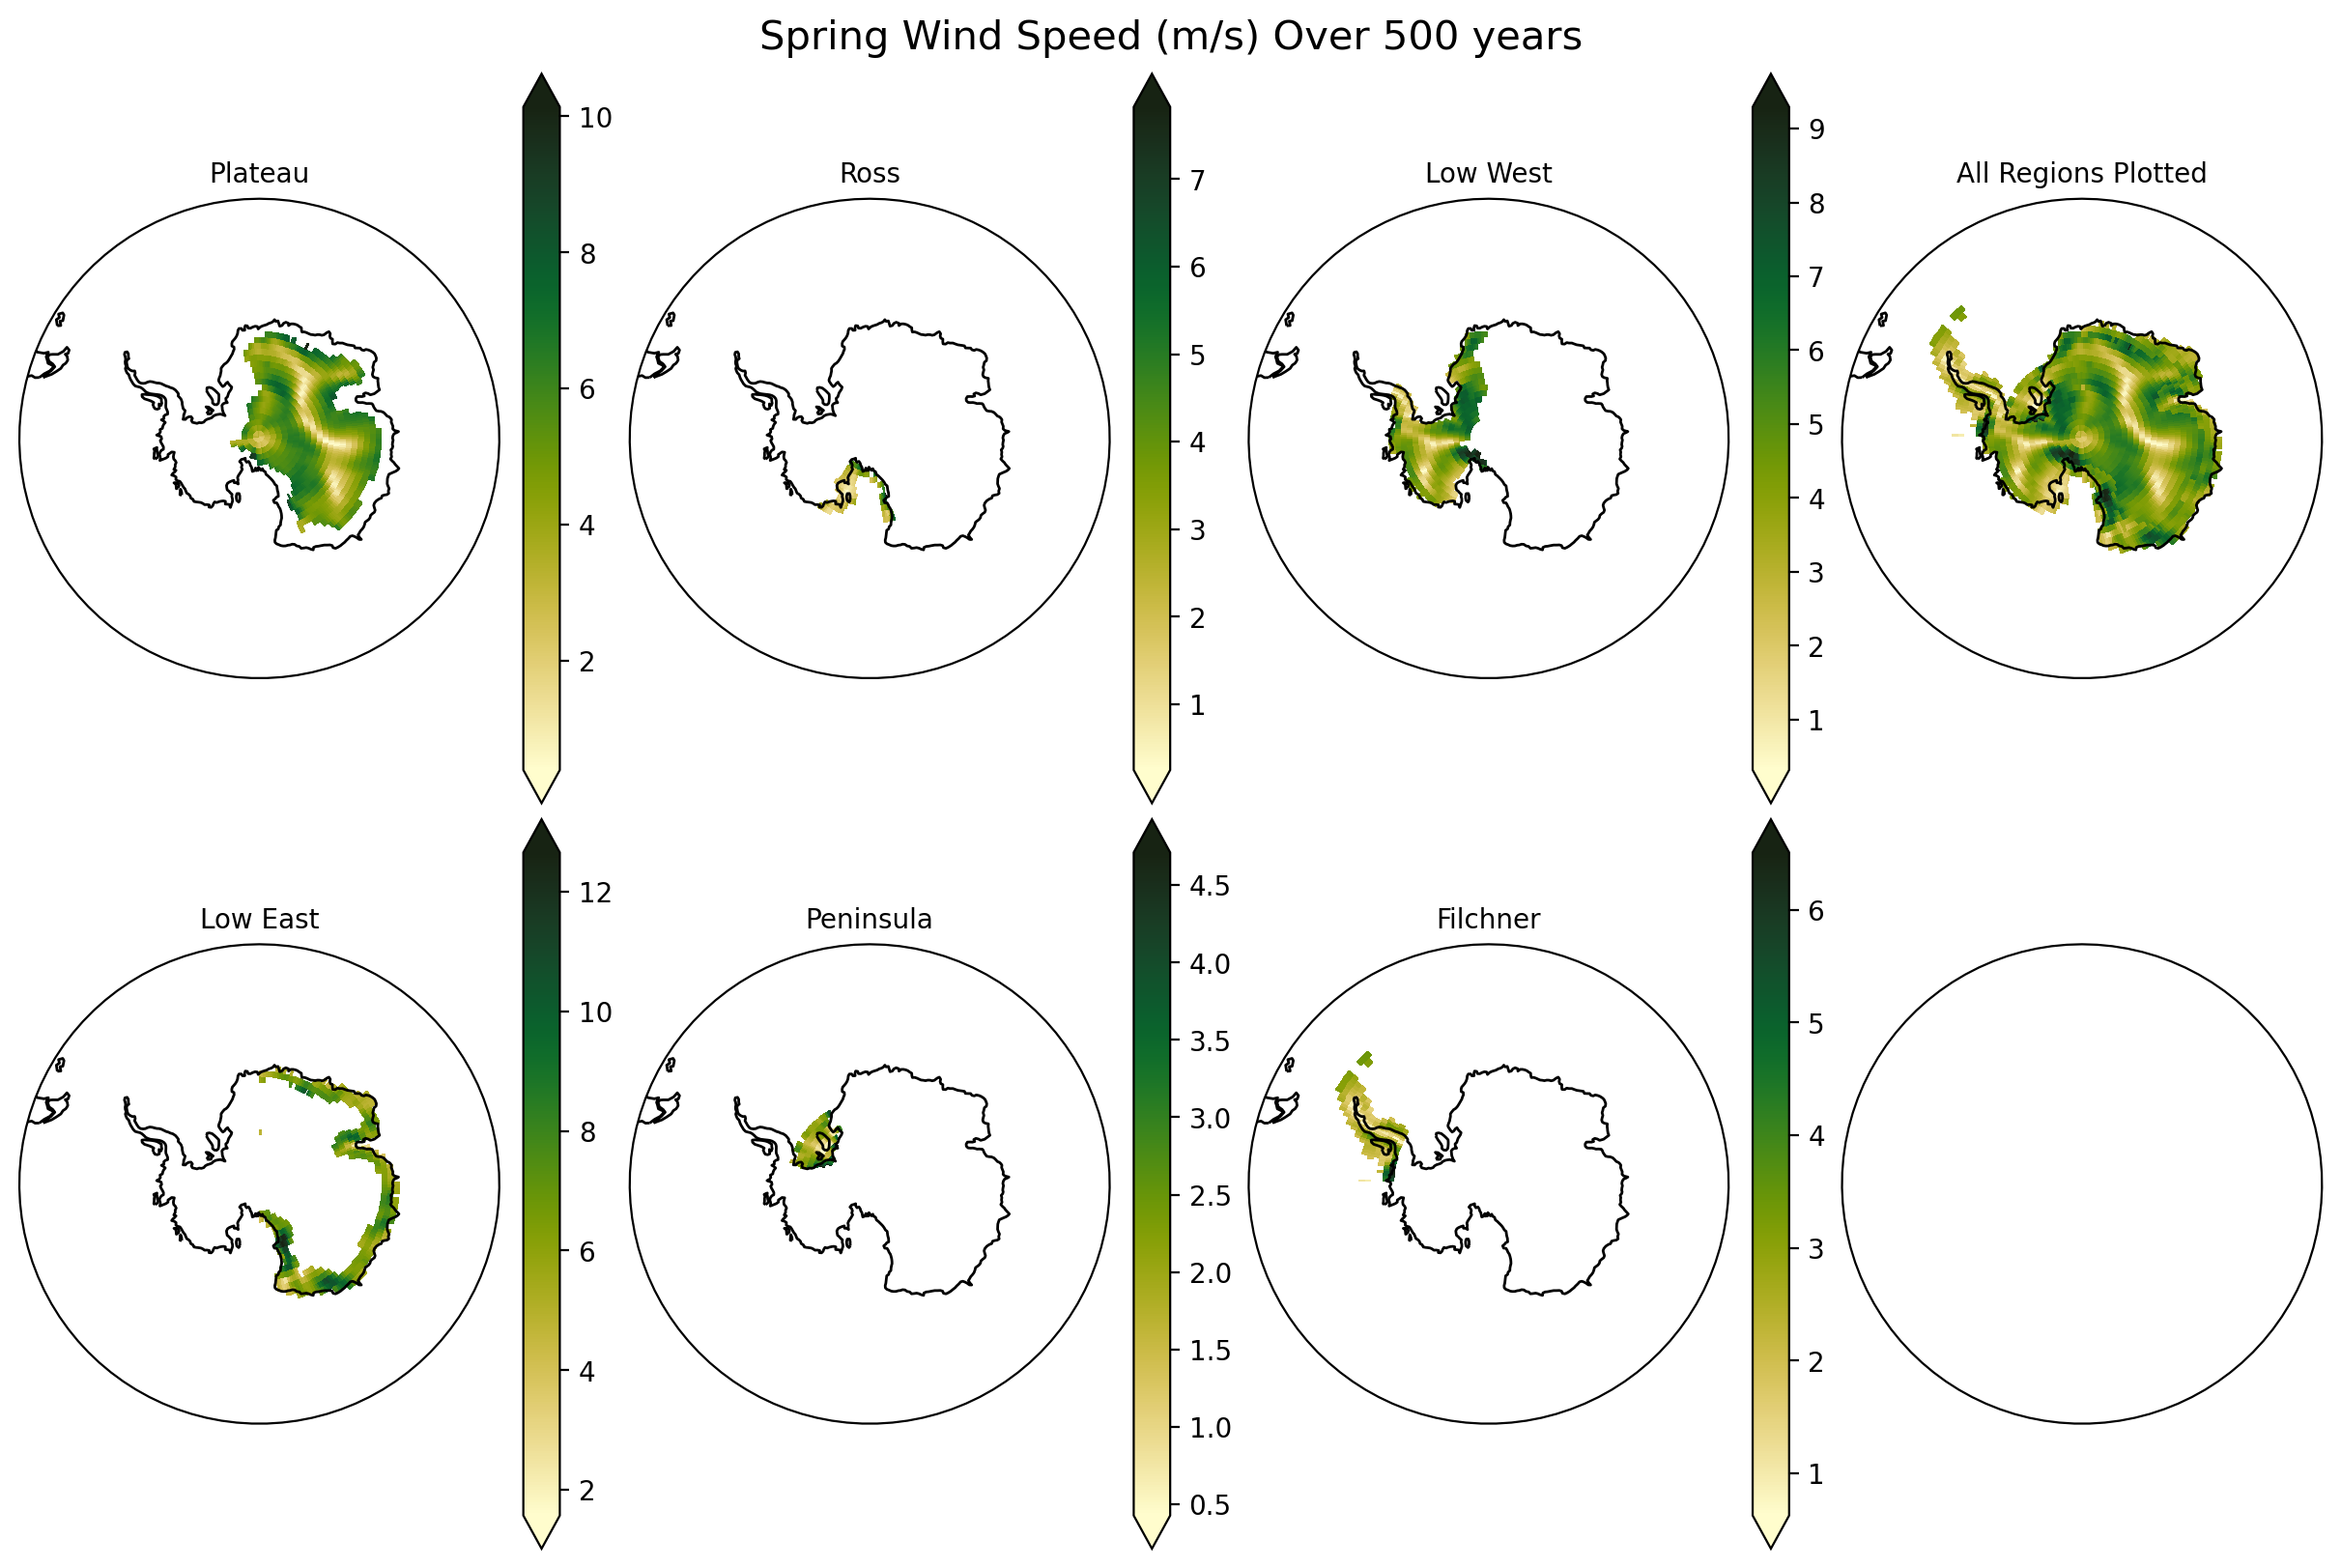

In [44]:
fig, ax = south_pole_map(cols=4, rows=2,fig_size=(12,8))
spring_plateau_speed.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
spring_ross_speed.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
spring_lowwest_speed.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed)
spring_loweast_speed.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
               extend='both',
               cmap= cmocean.cm.speed)
spring_filchner_speed.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
spring_peninsula_speed.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
spring_plateau_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
spring_ross_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
spring_lowwest_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
spring_loweast_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
spring_filchner_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
spring_peninsula_speed.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[0,3].coastlines()
ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[0,3].set_title('All Regions Plotted',size=10)
fig.suptitle('Spring Wind Speed (m/s) Over 500 years', fontsize=15)

# <span style="color:red">ESM4 DATA</span>

In [ ]:
ESM4_speedslice #average wind speed over 500 yr 

In [51]:
plateau_ESM4=(ESM4_speedslice*(mask_ESM4.plateau_ESM4))
ross_ESM4=(ESM4_speedslice*(mask_ESM4.ross_ESM4))
lowwest_ESM4=(ESM4_speedslice*(mask_ESM4.lowwest_ESM4))
loweast_ESM4=(ESM4_speedslice*(mask_ESM4.loweast_ESM4))
filchner_ESM4=(ESM4_speedslice*(mask_ESM4.filchner_ESM4))
peninsula_ESM4=(ESM4_speedslice*(mask_ESM4.peninsula_ESM4))

AttributeError: Rectangle.set() got an unexpected keyword argument 'extend'

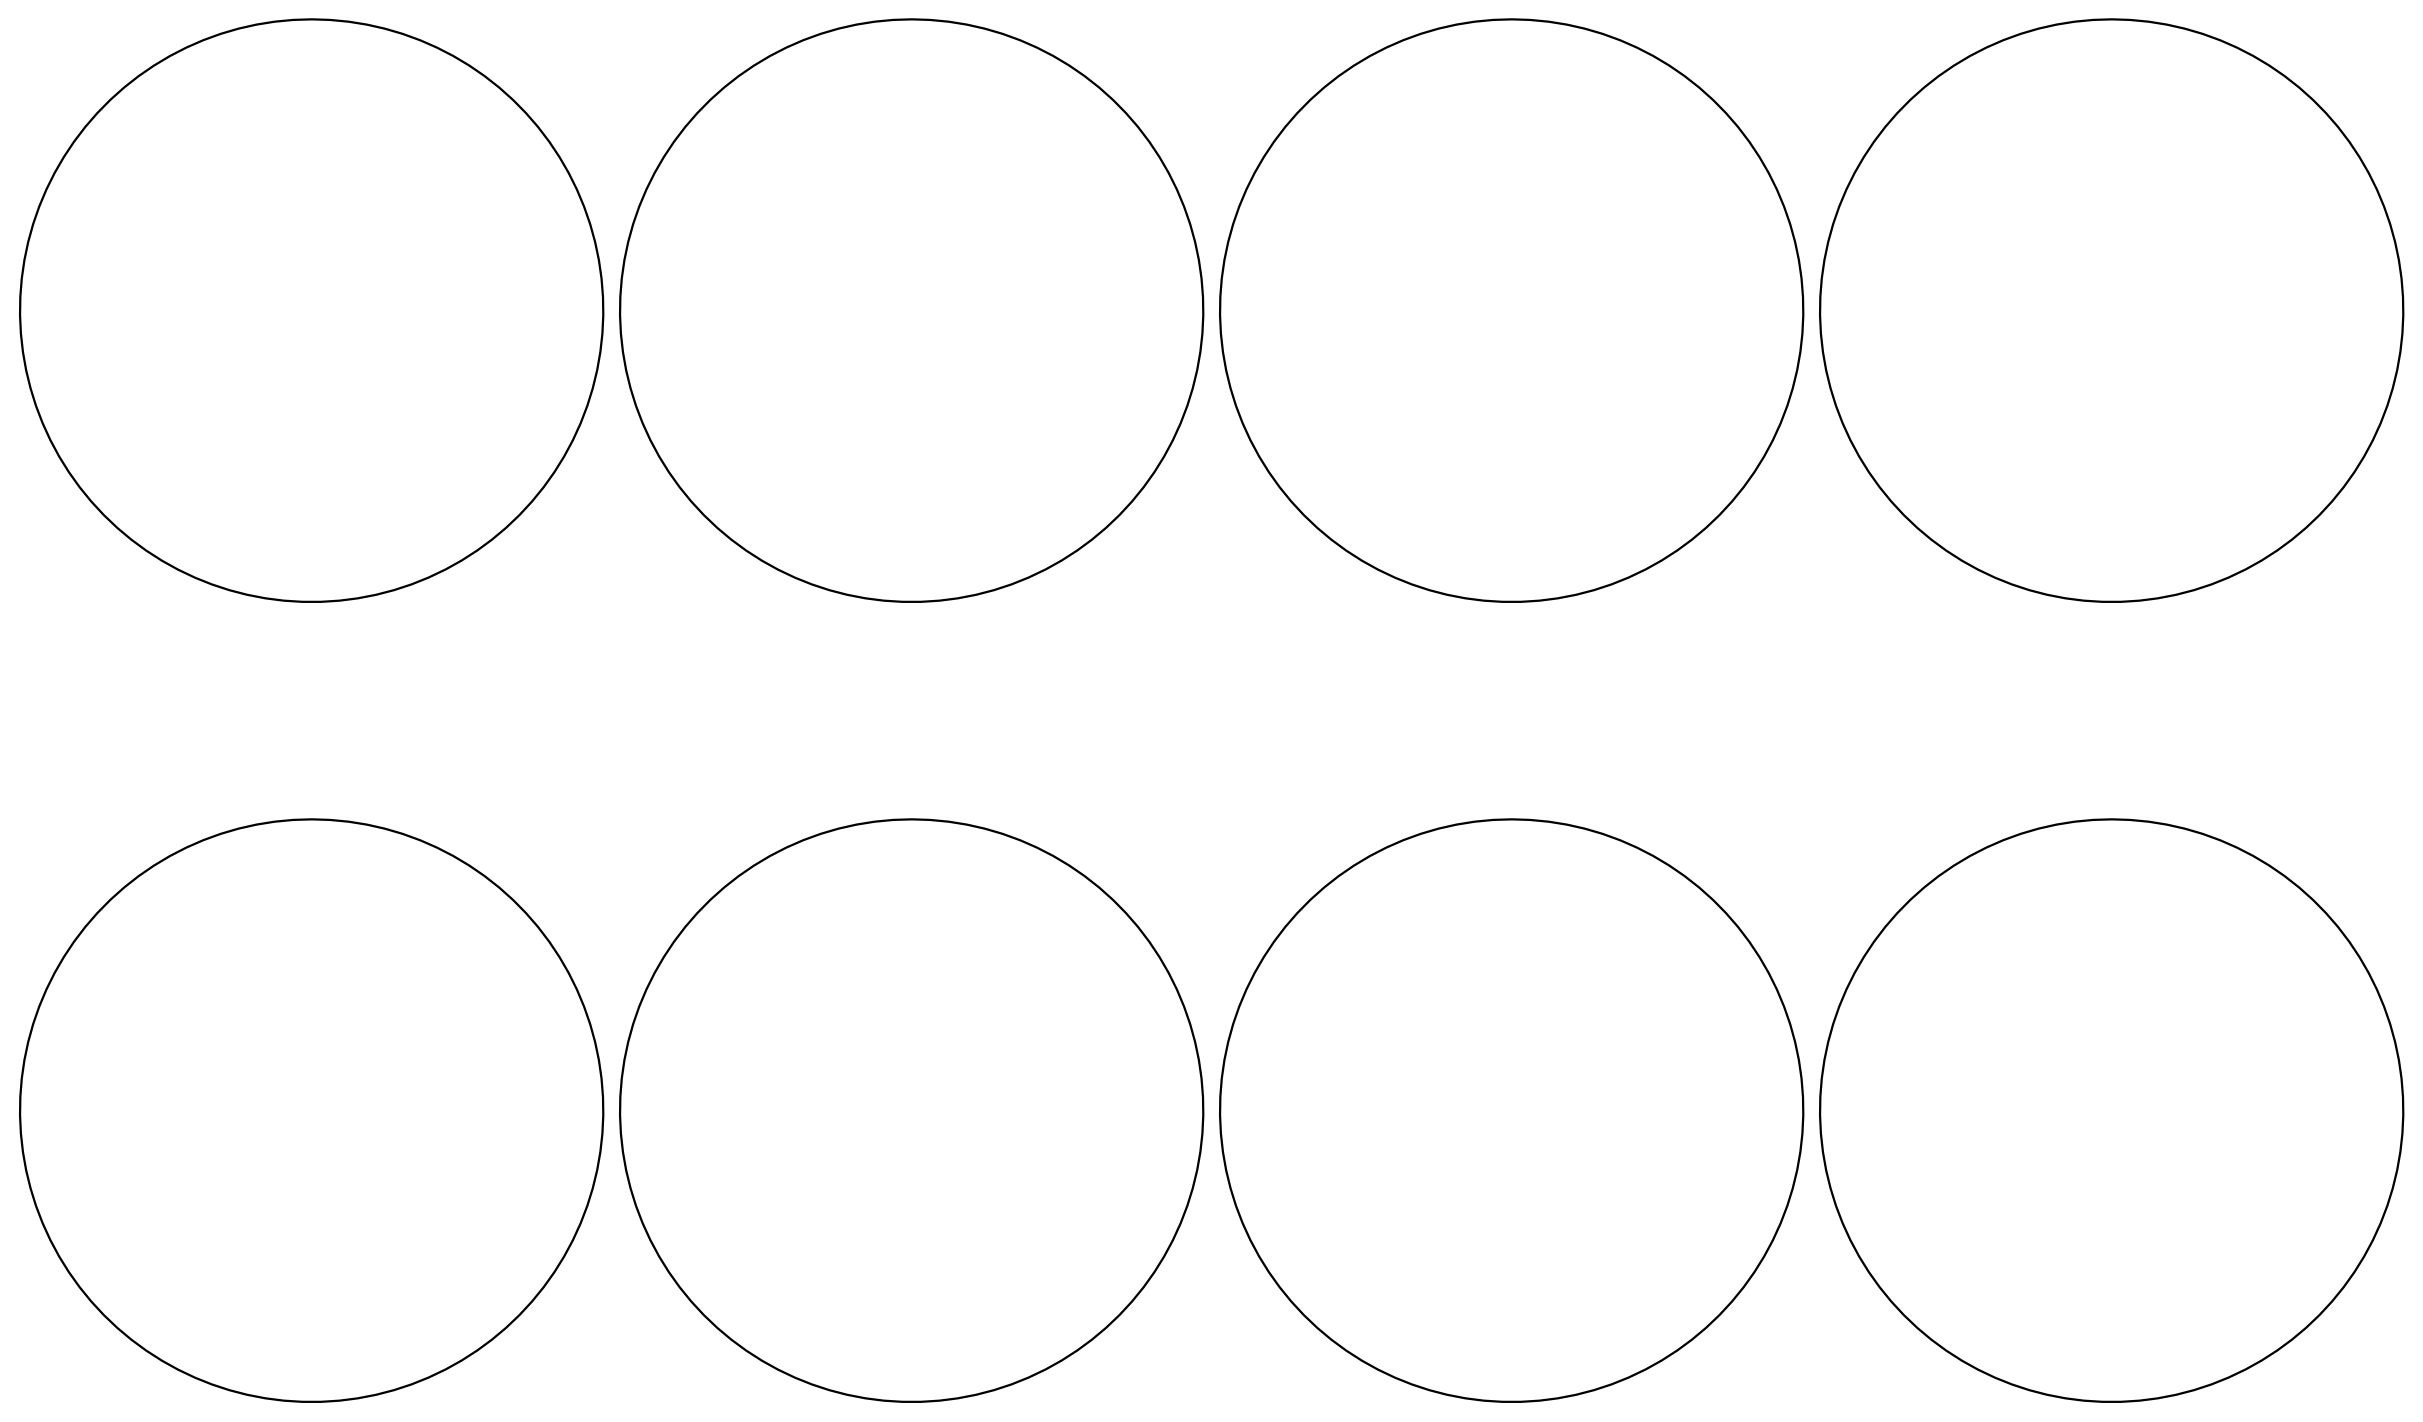

In [52]:
fig, ax = south_pole_map(cols=4, rows=2,fig_size=(12,8))
plateau_ESM4.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
ross_ESM4.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
lowwest_ESM4.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed)
loweast_ESM4.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
               extend='both',
               cmap= cmocean.cm.speed)
filchner_ESM4.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
peninsula_ESM4.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              extend='both',
              cmap=cmocean.cm.speed)
plateau_ESM4.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
ross_ESM4.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
lowwest_ESM4.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
loweast_ESM4.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
filchner_ESM4.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
filchner_ESM4.plot(ax=ax[0,3],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.speed, add_colorbar=False)
ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[0,3].coastlines()
ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[0,3].set_title('All Regions Plotted',size=10)
fig.suptitle('ESM4 Averaged Wind Speed (m/s) Over 500 years', fontsize=15)

In [ ]:
plateau_ESM4=(ESM4_speedslice*(mask_ESM4.plateau_ESM4))
ross_ESM4=(ESM4_speedslice*(mask_ESM4.ross_ESM4))
lowwest_ESM4=(ESM4_speedslice*(mask_ESM4.lowwest_ESM4))
loweast_ESM4=(ESM4_speedslice*(mask_ESM4.loweast_ESM4))
filchner_ESM4=(ESM4_speedslice*(mask_ESM4.filchner_ESM4))
peninsula_ESM4=(ESM4_speedslice*(mask_ESM4.peninsula_ESM4))